# Entregable Práctica 1: Graph Neural Networks

**Autor:** Jordi Blasco Lozano

---

### Índice

- [1. Funciones a utilizar](#funciones)
- [2. Ejercicio 1: Dataset Sintético](#ejercicio1)
- [3. Ejercicio 2: Experimentos de Clasificación de Nodos](#ejercicio2)

---

In [86]:
# Imports necesarios
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import degree

# Configuración de reproducibilidad
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Definir dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Configuración de visualización
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Using device: {device}")

PyTorch version: 2.7.1+cu118
CUDA available: True
Using device: cuda


<a id="funciones"></a>
## 1. Funciones a utilizar

En esta sección se definen todas las clases y funciones auxiliares necesarias para la práctica. Esto incluye la definición de los modelos (MLP y GCN), funciones de utilidad para grafos y visualización, y la clase `GraphTrainer` para gestionar los entrenamientos.

In [87]:
# ==========================================
# UTILIDADES DE GRAFO Y VISUALIZACIÓN
# ==========================================

def create_masks(num_nodes, num_classes, train_ratio=0.6, val_ratio=0.2, seed=0):
    """
    Create train/val/test masks for node classification.
    """
    np.random.seed(seed)
    
    indices = np.random.permutation(num_nodes)
    train_size = int(num_nodes * train_ratio)
    val_size = int(num_nodes * val_ratio)
    
    train_idx = indices[:train_size]
    # val_idx = indices[train_size+val_size:train_size+val_size] # Typo in original fix? No, original had logic.
    # Fixed logic:
    val_idx = indices[train_size:train_size + val_size]
    test_idx = indices[train_size + val_size:]
    
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    val_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)
    
    train_mask[train_idx] = True
    val_mask[val_idx] = True
    test_mask[test_idx] = True
    
    return train_mask, val_mask, test_mask

def efficient_message_passing(x, edge_index, weight_matrix):
    """
    Efficient message passing using scatter operations.
    For visualization/debugging of message passing mechanics.
    """
    num_nodes = x.size(0)
    
    # 1. Asegurar que edge_index está en el mismo dispositivo que x
    if edge_index.device != x.device:
        edge_index = edge_index.to(x.device)
        
    # 2. Asegurar que weight_matrix está en el mismo dispositivo
    if weight_matrix.device != x.device:
        weight_matrix = weight_matrix.to(x.device)

    # Transform features
    x_transformed = x @ weight_matrix
    
    # Get source and target nodes
    source_nodes = edge_index[0]
    target_nodes = edge_index[1]
    
    # Gather source node features for each edge
    messages = x_transformed[source_nodes]  # [num_edges, out_features]
    
    # Scatter-add: aggregate messages to target nodes
    # Ensure out is on the SAME DEVICE as x_transformed
    out = torch.zeros(num_nodes, x_transformed.size(1), device=x_transformed.device)
    
    # target_nodes ya está en el dispositivo correcto tras el paso 1
    out.scatter_add_(0, target_nodes.unsqueeze(1).expand_as(messages), messages)
    
    # Normalize by degree
    deg = degree(target_nodes, num_nodes=num_nodes)
    deg = torch.clamp(deg, min=1)
    out = out / deg.unsqueeze(1)
    
    # Apply non-linearity
    out = F.relu(out)
    
    return out

def visualize_embeddings(embeddings, labels, title, num_classes=4):
    """
    Visualize node embeddings using t-SNE.
    """
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.detach().cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
        
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10, 8))
    colors = sns.color_palette("husl", num_classes)
    
    for class_idx in range(num_classes):
        mask = labels == class_idx
        plt.scatter(
            embeddings_2d[mask, 0],
            embeddings_2d[mask, 1],
            color=colors[class_idx],
            label=f'Class {class_idx}',
            alpha=0.7,
            s=50
        )
    
    plt.legend()
    plt.title(title)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [88]:
# ==========================================
# DEFINICIÓN DE MODELOS
# ==========================================

class MLP(nn.Module):
    """
    Simple Multi-Layer Perceptron for node classification.
    This baseline ignores the graph structure.
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(in_channels, hidden_channels)
        self.fc2 = nn.Linear(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index=None): 
        # Note: edge_index is accepted but ignored to keep interface consistent
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class GCN(nn.Module):
    """
    Graph Convolutional Network for node classification.
    """
    
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, edge_index):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        # Second GCN layer
        x = self.conv2(x, edge_index)
        return x

In [89]:
# ==========================================
# CLASE DE ENTRENAMIENTO (TRAINER)
# ==========================================

class GraphTrainer:
    """
    Clase para gestionar el entrenamiento y evaluación de modelos de grafos.
    Permite entrenar múltiples modelos/configuraciones y almacenar resultados limpios.
    """
    def __init__(self, device='cpu'):
        self.device = device
        self.experiments = {} # Almacena historial y resultados por 'run_name'
        
    def train_model(self, 
                    model_class, 
                    model_params, 
                    data, 
                    masks, 
                    optimizer_cls=torch.optim.Adam, 
                    lr=0.01, 
                    weight_decay=5e-4, 
                    num_epochs=200, 
                    run_name="experiment"):
        """
        Entrena un único modelo y guarda sus estadísticas.
        """
        # Preparar modelo y datos
        model = model_class(**model_params).to(self.device)
        data = data.to(self.device)
        optimizer = optimizer_cls(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.CrossEntropyLoss()
        
        train_mask = masks['train']
        val_mask = masks['val']
        test_mask = masks['test']
        
        history = []
        best_val_acc = 0
        best_test_acc = 0
        
        # Bucle de entrenamiento sin prints excesivos
        epochs_range = tqdm(range(num_epochs), desc=f"Training {run_name}", leave=False) # Barra de progreso opcional
        for epoch in epochs_range:
            # Training step
            model.train()
            optimizer.zero_grad()
            
            # Soporte dual para MLP (solo x) y GCN (x, edge_index)
            out = model(data.x, data.edge_index)
            loss = criterion(out[train_mask], data.y[train_mask])
            loss.backward()
            optimizer.step()
            
            # Evaluation step
            model.eval()
            with torch.no_grad():
                out_eval = model(data.x, data.edge_index)
                pred = out_eval.argmax(dim=1)
                
                train_acc = (pred[train_mask] == data.y[train_mask]).sum().item() / train_mask.sum().item()
                val_acc = (pred[val_mask] == data.y[val_mask]).sum().item() / val_mask.sum().item()
                test_acc = (pred[test_mask] == data.y[test_mask]).sum().item() / test_mask.sum().item()
            
            # Guardar mejor modelo (Early stopping 'soft' - trackeamos el mejor val)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_test_acc = test_acc
            
            history.append({
                'epoch': epoch + 1,
                'loss': loss.item(),
                'train_acc': train_acc,
                'val_acc': val_acc,
                'test_acc': test_acc
            })
            
        # Parse Run ID if present (e.g. "MLP_Run_0" -> 0)
        try:
            run_id = int(run_name.split('_')[-1])
        except ValueError:
            run_id = np.nan

        # Almacenar resultados del experimento
        self.experiments[run_name] = {
            'history': pd.DataFrame(history),
            'final_results': {
                'Model': run_name.split('_')[0], 
                'Run': run_id, # Integer run number if possible
                'Run_Name': run_name,
                'Best Val Acc': best_val_acc,
                'Test Acc': best_test_acc
            }
        }
        
    def train_batch(self, config_list, data, multiple_masks=None):
        """
        Entrena múltiples configuraciones en lote.
        """
        for i, config in enumerate(tqdm(config_list, desc="Training models")):
            # Si tenemos máscaras rotativas (para las 10 runs del ejercicio 1)
            current_masks = multiple_masks[i] if multiple_masks is not None else config.get('masks')
            
            # Copiar config y actualizar masks
            run_config = config.copy()
            run_config['data'] = data
            run_config['masks'] = current_masks
            
            self.train_model(**run_config)
            
    def get_training_curves(self, run_names=None):
        if run_names is None:
            run_names = list(self.experiments.keys())
            
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        for name in run_names:
            if name not in self.experiments: continue
            df = self.experiments[name]['history']
            
            axes[0].plot(df['epoch'], df['loss'], label=name, alpha=0.7)
            axes[1].plot(df['epoch'], df['train_acc'], label=name, alpha=0.7)
            axes[2].plot(df['epoch'], df['val_acc'], label=name, alpha=0.7)
            
        titles = ['Training Loss', 'Training Accuracy', 'Validation Accuracy']
        for i, ax in enumerate(axes):
            ax.set_title(titles[i])
            ax.set_xlabel('Epoch')
            ax.legend()
            ax.grid(True, alpha=0.3)
            
        plt.tight_layout()
        plt.show()

    def get_results_df(self):
        """
        Devuelve un DataFrame resumen básico.
        """
        results = [exp['final_results'] for exp in self.experiments.values()]
        return pd.DataFrame(results)

    def get_pivoted_results(self, metric='Test Acc'):
        """
        Retorna los resultados pivoteados: Modelos en filas, Runs en columnas.
        Útil para el Ejercicio 2A.
        """
        df = self.get_results_df()
        # Filtrar solo si 'Run' es numérico (excluir experimentos sueltos como Cora/Citeseer)
        df_runs = df.dropna(subset=['Run'])
        if df_runs.empty:
            return pd.DataFrame() 
            
        # Pivot table
        pivot_df = df_runs.pivot(index='Model', columns='Run', values=metric)
        
        # Eliminar el nombre del índice de las columnas ("Run") para que quede limpio en el display
        pivot_df.columns.name = None
        pivot_df.index.name = "Model / Run"
        
        return pivot_df

    def plot_bar_results(self, title_suffix=""):
        """
        Plotea un gráfico de barras comparando la media de Test Acc por Modelo.
        """
        df = self.get_results_df()
        if df.empty: return
        
        plt.figure(figsize=(10, 6))
        # Remove Runs column to aggregate by Model easily if mixed
        # Actually seaborn barplot checks all repetitions for error bars automatically
        
        sns.barplot(data=df, x='Model', y='Test Acc', hue='Model', errorbar='sd', capsize=.1, dodge=False)
        plt.title(f'Comparación de Accuracy en Test {title_suffix}')
        plt.ylim(0, 1.1)
        plt.ylabel("Test Accuracy")
        plt.grid(axis='y', alpha=0.3)
        plt.show()

<a id="ejercicio1"></a>
## 2. Ejercicio 1: Dataset Sintético

En este ejercicio generaremos un grafo sintético utilizando el Modelo de Bloques Estocásticos (Stochastic Block Model).

In [90]:
# Generar 10 máscaras aleatorias (splits)
num_runs = 10
splits_masks = []
for i in range(num_runs):
    splits_masks.append(
        dict(zip(['train', 'val', 'test'], create_masks(custom_data.num_nodes, num_classes, seed=i)))
    )

# Inicializar Entrenador
trainer_custom = GraphTrainer(device=device)

# Configuraciones para MLP (10 runs)
mlp_configs = [{
    'run_name': f'MLP_Run_{i}',
    'model_class': MLP,
    'model_params': {'in_channels': custom_data.num_node_features, 'hidden_channels': 64, 'out_channels': num_classes},
    'lr': 0.01,
    'num_epochs': 200
} for i in range(num_runs)]

# Configuraciones para GCN (10 runs)
gcn_configs = [{
    'run_name': f'GCN_Run_{i}',
    'model_class': GCN,
    'model_params': {'in_channels': custom_data.num_node_features, 'hidden_channels': 64, 'out_channels': num_classes},
    'lr': 0.01,
    'num_epochs': 200
} for i in range(num_runs)]

# Entrenar en lote
print("Entrenando MLPs...")
trainer_custom.train_batch(mlp_configs, custom_data, multiple_masks=splits_masks)

print("Entrenando GCNs...")
trainer_custom.train_batch(gcn_configs, custom_data, multiple_masks=splits_masks)


Entrenando MLPs...


Training models:   0%|          | 0/10 [00:00<?, ?it/s]

Training MLP_Run_0:   0%|          | 0/200 [00:00<?, ?it/s]

Training MLP_Run_1:   0%|          | 0/200 [00:00<?, ?it/s]

Training MLP_Run_2:   0%|          | 0/200 [00:00<?, ?it/s]

Training MLP_Run_3:   0%|          | 0/200 [00:00<?, ?it/s]

Training MLP_Run_4:   0%|          | 0/200 [00:00<?, ?it/s]

Training MLP_Run_5:   0%|          | 0/200 [00:00<?, ?it/s]

Training MLP_Run_6:   0%|          | 0/200 [00:00<?, ?it/s]

Training MLP_Run_7:   0%|          | 0/200 [00:00<?, ?it/s]

Training MLP_Run_8:   0%|          | 0/200 [00:00<?, ?it/s]

Training MLP_Run_9:   0%|          | 0/200 [00:00<?, ?it/s]

Entrenando GCNs...


Training models:   0%|          | 0/10 [00:00<?, ?it/s]

Training GCN_Run_0:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Run_1:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Run_2:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Run_3:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Run_4:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Run_5:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Run_6:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Run_7:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Run_8:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Run_9:   0%|          | 0/200 [00:00<?, ?it/s]

In [91]:

# ==========================================
# RESULTADOS 
# ==========================================

print("\nResultados TEST Accuracy por Run:")
df_test_pivot = trainer_custom.get_pivoted_results(metric='Test Acc')
df_display_test = df_test_pivot.reset_index()
numeric_cols = df_display_test.columns[1:] 
display(df_display_test.style.hide(axis='index'))

print("\nResultados VALIDATION Accuracy por Run:")
df_val_pivot = trainer_custom.get_pivoted_results(metric='Best Val Acc')
df_display_val = df_val_pivot.reset_index()
display(df_display_val.style.hide(axis='index'))



Resultados TEST Accuracy por Run:


Model / Run,0,1,2,3,4,5,6,7,8,9
GCN,0.997500,0.997500,0.997500,1.000000,1.000000,1.000000,0.997500,0.995000,1.000000,0.997500
MLP,0.292500,0.297500,0.267500,0.275000,0.260000,0.267500,0.302500,0.280000,0.282500,0.262500



Resultados VALIDATION Accuracy por Run:


Model / Run,0,1,2,3,4,5,6,7,8,9
GCN,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
MLP,0.312500,0.297500,0.292500,0.310000,0.307500,0.337500,0.285000,0.307500,0.295000,0.292500



Estadísticas Globales (Test Accuracy):


,mean,std,min,max
Model,,,,
GCN,0.99825,0.001687,0.995,1.0000
MLP,0.27875,0.014919,0.260,0.3025


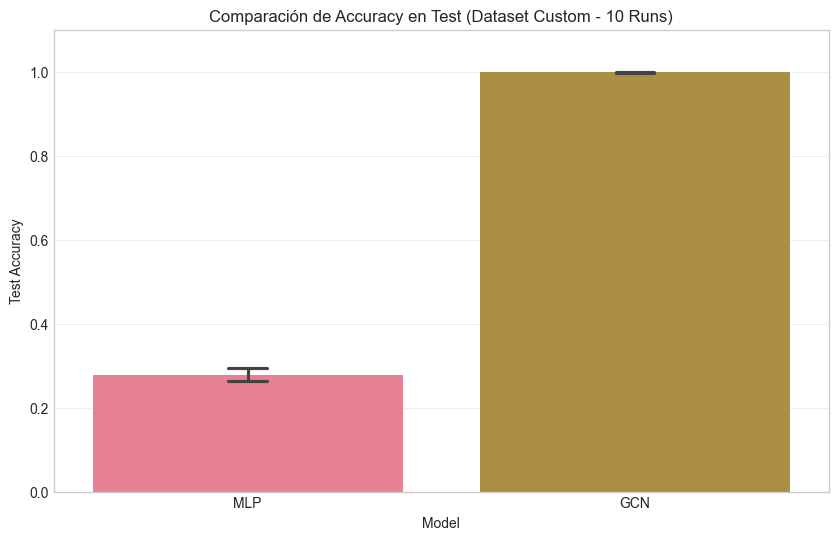

In [104]:

# Calcular estadísticas
print("\nEstadísticas Globales (Test Accuracy):")
summary_custom = trainer_custom.get_results_df().groupby('Model')['Test Acc'].agg(['mean', 'std', 'min', 'max'])
display(summary_custom)

# Plots
trainer_custom.plot_bar_results(title_suffix="(Dataset Custom - 10 Runs)")

### Visualización del Grafo y Embeddings

A continuación mostramos la estructura del grafo (comunidades) y cómo se ven las características antes y después de aplicar *Message Passing*.

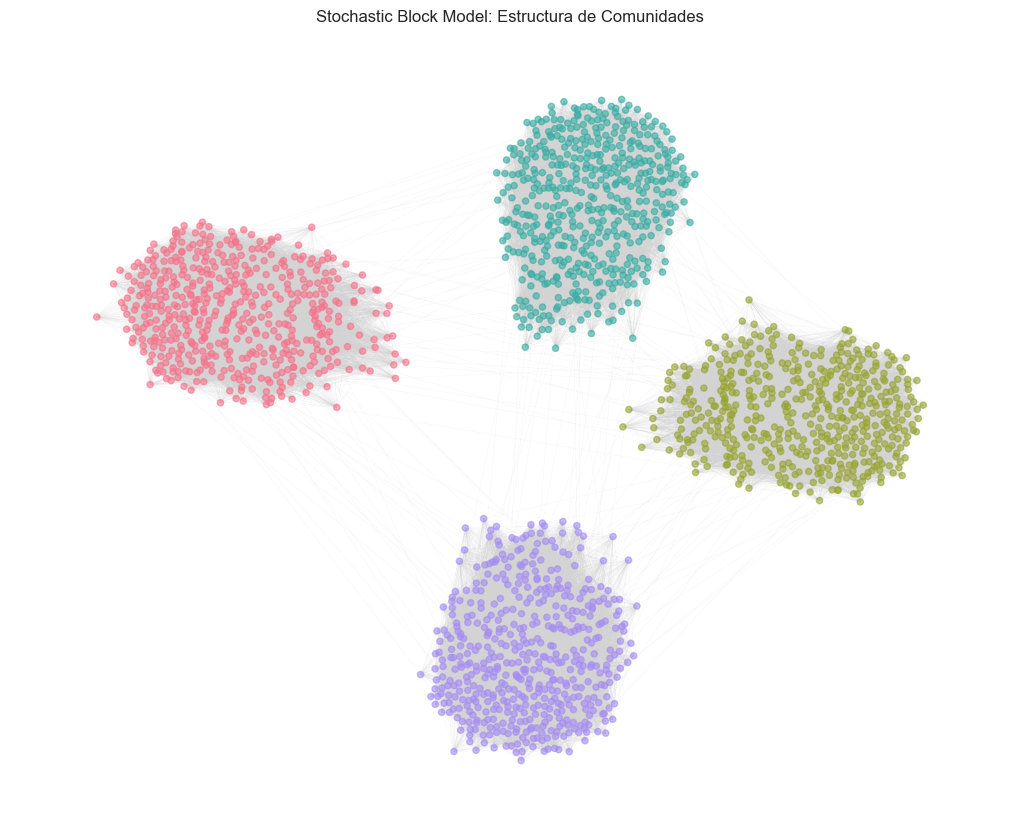

In [96]:
# Visualización 1: Estructura del Grafo
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G, seed=42, k=0.15, iterations=20) # Ajustado k para mejor visualización de clusters
node_colors = [sns.color_palette("husl", num_classes)[label] for label in node_labels]

nx.draw(G, pos, node_color=node_colors, node_size=20, 
        edge_color='lightgray', alpha=0.6, width=0.1)
plt.title("Stochastic Block Model: Estructura de Comunidades")
plt.show()


Generando t-SNE de features iniciales...


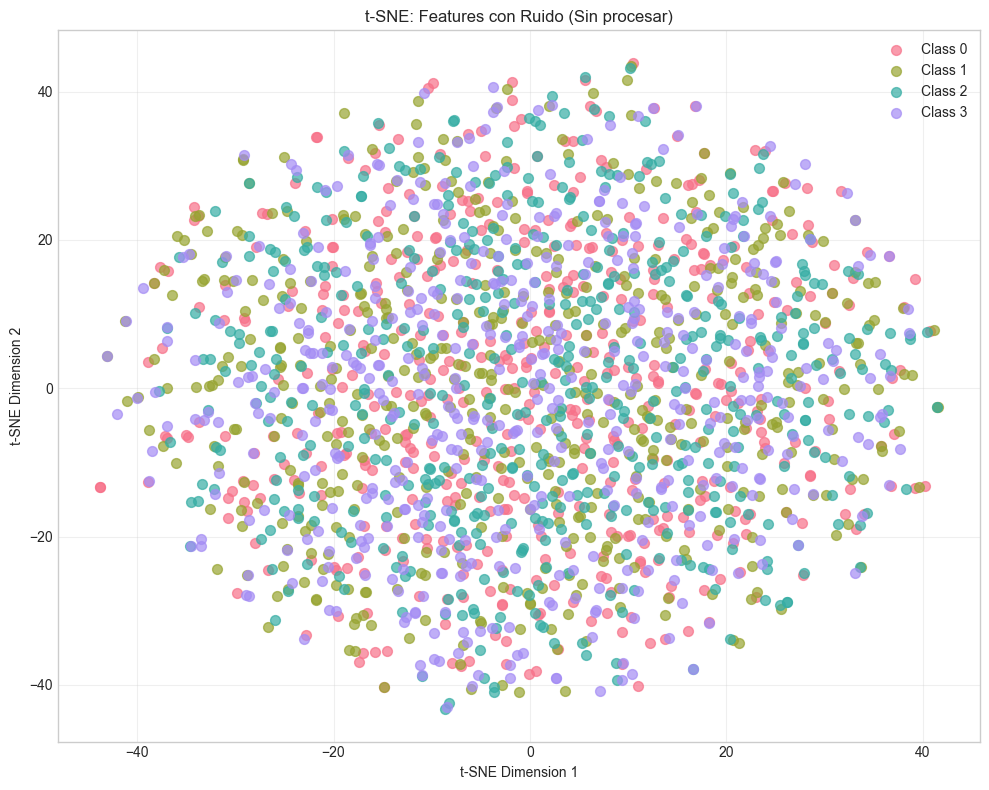

In [97]:

# Visualización 2: Features Originales (t-SNE)
print("Generando t-SNE de features iniciales...")
visualize_embeddings(custom_data.x, custom_data.y, "t-SNE: Features con Ruido (Sin procesar)")


Aplicando 2 capas de Message Passing simulado...


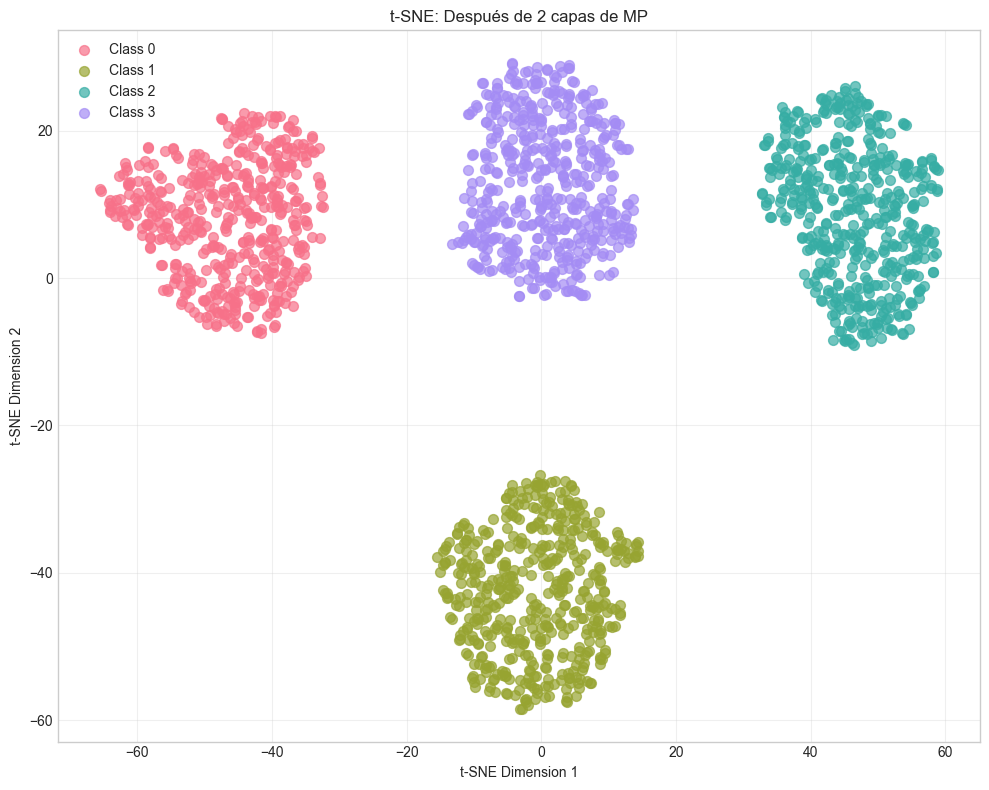

In [98]:

# Visualización 3: Efecto del Message Passing (Simulación)
print("Aplicando 2 capas de Message Passing simulado...")

# Asegurar que custom_data.x es un tensor
if not isinstance(custom_data.x, torch.Tensor):
    custom_data.x = torch.tensor(custom_data.x, dtype=torch.float)

# Detectar dispositivo
device_current = custom_data.x.device

# Crear pesos en el MISMO dispositivo que los datos
W1 = torch.randn(feature_dim, 32, device=device_current) * 0.1
W2 = torch.randn(32, 16, device=device_current) * 0.1

# Asegurar edge_index tambien en el mismo dispositivo
if custom_data.edge_index.device != device_current:
    custom_data.edge_index = custom_data.edge_index.to(device_current)

h1 = efficient_message_passing(custom_data.x, custom_data.edge_index, W1)
h2 = efficient_message_passing(h1, custom_data.edge_index, W2)

visualize_embeddings(h2, custom_data.y, "t-SNE: Después de 2 capas de MP")

<a id="ejercicio2"></a>
## 3. Ejercicio 2: Experimentos de Clasificación de Nodos

### Parte A: Dataset Sintético (10 Runs)

Entrenaremos modelos MLP y GCN sobre 10 particiones aleatorias diferentes del dataset sintético para evaluar su robustez.

In [99]:
# Cargar Datasets
dataset_cora = Planetoid(root='./data', name='Cora')
data_cora = dataset_cora[0]
dataset_citeseer = Planetoid(root='./data', name='Citeseer')
data_citeseer = dataset_citeseer[0]

# Entrenador para Benchmarks
trainer_bench = GraphTrainer(device=device)

# --- DEFINICIÓN DE CONFIGURACIONES ---
# Usaremos listas para iterar fácilmente

configs_bench = []

# 1. Cora - MLP vs GCN
configs_bench.append({
    'run_name': 'MLP_Cora',
    'model_class': MLP,
    'model_params': {'in_channels': dataset_cora.num_node_features, 'hidden_channels': 64, 'out_channels': dataset_cora.num_classes},
    'data': data_cora,
    'masks': {'train': data_cora.train_mask, 'val': data_cora.val_mask, 'test': data_cora.test_mask},
})
configs_bench.append({
    'run_name': 'GCN_Cora',
    'model_class': GCN,
    'model_params': {'in_channels': dataset_cora.num_node_features, 'hidden_channels': 64, 'out_channels': dataset_cora.num_classes},
    'data': data_cora,
    'masks': {'train': data_cora.train_mask, 'val': data_cora.val_mask, 'test': data_cora.test_mask},
})

# 2. Citeseer - MLP vs GCN
configs_bench.append({
    'run_name': 'MLP_Citeseer',
    'model_class': MLP,
    'model_params': {'in_channels': dataset_citeseer.num_node_features, 'hidden_channels': 64, 'out_channels': dataset_citeseer.num_classes},
    'data': data_citeseer,
    'masks': {'train': data_citeseer.train_mask, 'val': data_citeseer.val_mask, 'test': data_citeseer.test_mask},
})
configs_bench.append({
    'run_name': 'GCN_Citeseer',
    'model_class': GCN,
    'model_params': {'in_channels': dataset_citeseer.num_node_features, 'hidden_channels': 64, 'out_channels': dataset_citeseer.num_classes},
    'data': data_citeseer,
    'masks': {'train': data_citeseer.train_mask, 'val': data_citeseer.val_mask, 'test': data_citeseer.test_mask},
})

# Entrenar todos
print("Entrenando modelos en Benchmark Datasets...")
for config in tqdm(configs_bench):
    # Parámetros comunes
    config['lr'] = 0.01
    config['weight_decay'] = 5e-4
    config['num_epochs'] = 200
    trainer_bench.train_model(**config)


Entrenando modelos en Benchmark Datasets...


  0%|          | 0/4 [00:00<?, ?it/s]

Training MLP_Cora:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Cora:   0%|          | 0/200 [00:00<?, ?it/s]

Training MLP_Citeseer:   0%|          | 0/200 [00:00<?, ?it/s]

Training GCN_Citeseer:   0%|          | 0/200 [00:00<?, ?it/s]

In [100]:

# Resultados
print("\nComparación Resultados Benchmarks:")
df_bench = trainer_bench.get_results_df()
# Limpiar tabla para que quede bonita
df_bench['Dataset'] = df_bench['Run_Name'].apply(lambda x: x.split('_')[1])
df_bench['Model_Type'] = df_bench['Run_Name'].apply(lambda x: x.split('_')[0])
df_table = df_bench[['Dataset', 'Model_Type', 'Test Acc', 'Best Val Acc']]

display(df_table.style)



Comparación Resultados Benchmarks:


,Dataset,Model_Type,Test Acc,Best Val Acc
0,Cora,MLP,0.580000,0.596000
1,Cora,GCN,0.813000,0.798000
2,Citeseer,MLP,0.576000,0.574000
3,Citeseer,GCN,0.686000,0.712000


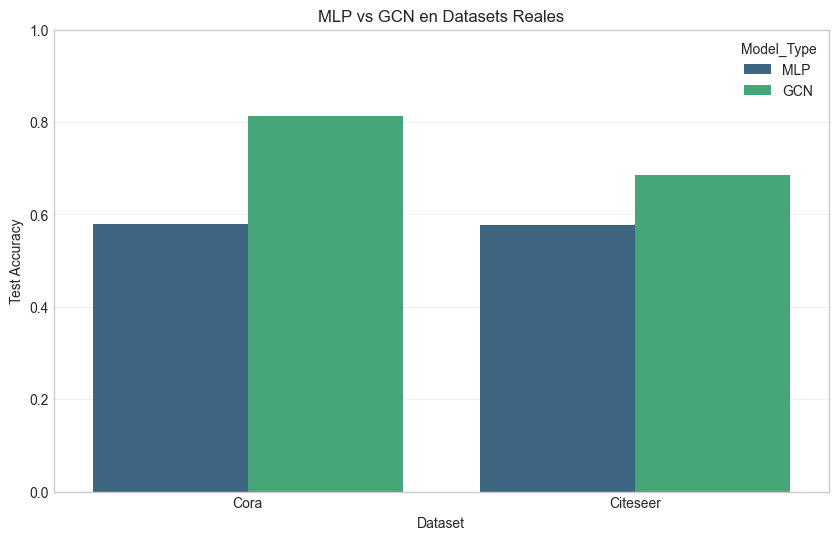

In [101]:

# Gráfico comparativo
plt.figure(figsize=(10, 6))
sns.barplot(data=df_bench, x='Dataset', y='Test Acc', hue='Model_Type', palette='viridis')
plt.title("MLP vs GCN en Datasets Reales")
plt.ylim(0, 1.0)
plt.ylabel("Test Accuracy")
plt.grid(axis='y', alpha=0.3)
plt.show()


Curvas de entrenamiento (Cora):


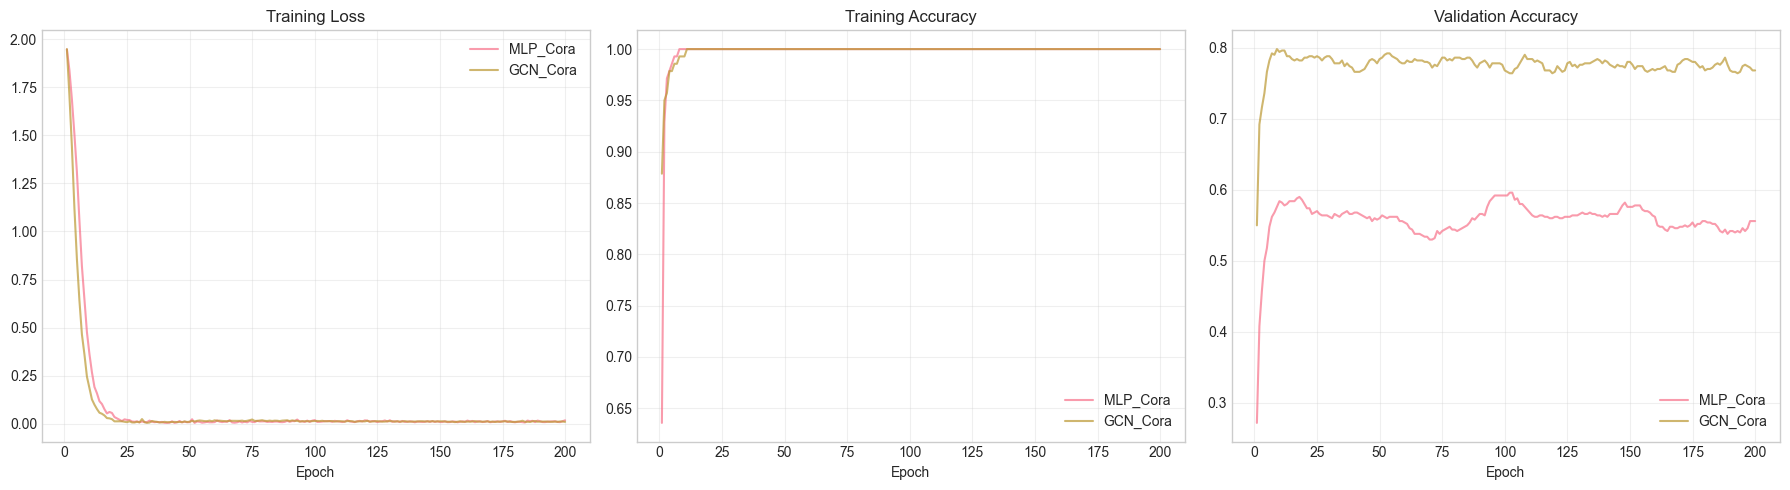

In [102]:

# Curvas de entrenamiento
print("Curvas de entrenamiento (Cora):")
trainer_bench.get_training_curves(run_names=['MLP_Cora', 'GCN_Cora'])


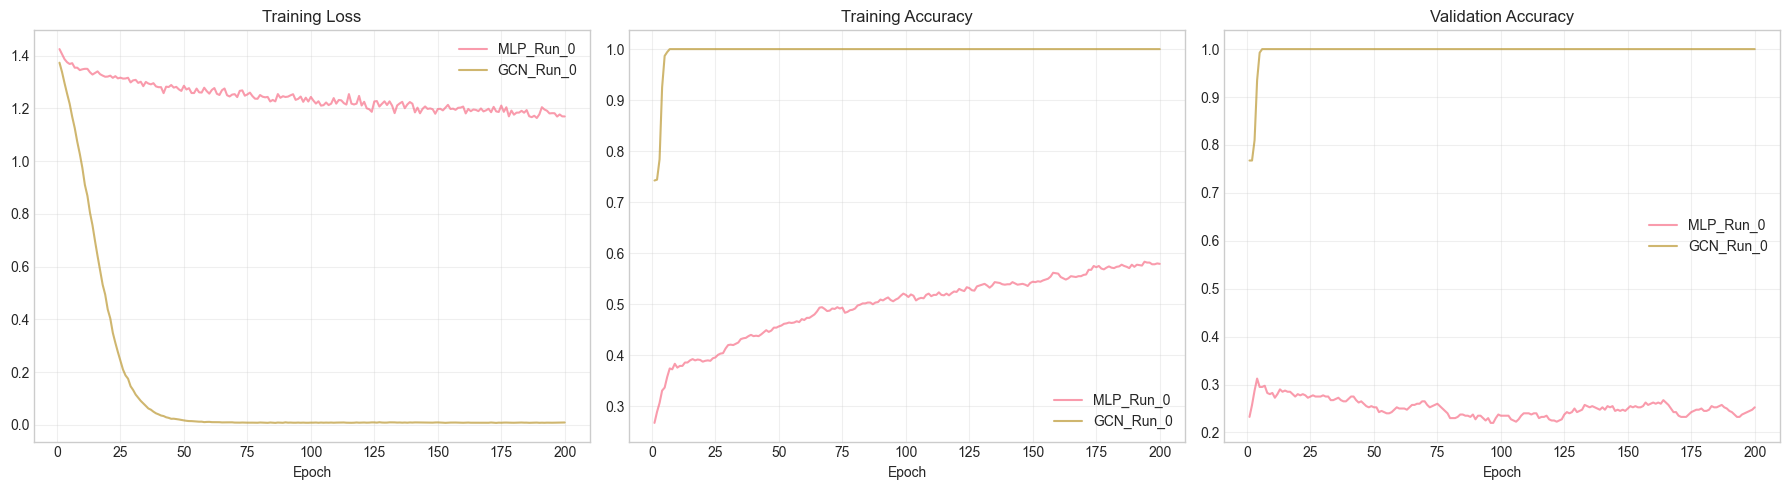

In [103]:
# Ver curvas de entrenamiento de un ejemplo (Run 0)
trainer_custom.get_training_curves(run_names=['MLP_Run_0', 'GCN_Run_0'])

### Parte B: Benchmark Datasets (Cora & Citeseer)

En esta sección probaremos la GCN en datasets del mundo real.